# Training Interpretable Networks?

This notebook presents an attempt at trying to get a neural network to learn interpretable modules, by replacing activations of a module on some input with another for input's provided they both evaluate to the same predicate for some predicate we decide. This induces the property expressed by the predicate in the module, thus making it easy to interpret, and has downstream effects on subsequent modules. This also seems to lead to a better performance, at least in the beginning of the training (more careful hyperparameter tuning might make a difference here)

In [1]:
%%capture
!pip install git+https://github.com/pranavgade20/causal-verifier.git

In [2]:
import torch as t
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

from causal_verifier import Predicate, Hook
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

2023-02-25 22:58:36.003156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
t.manual_seed(0)

In [4]:
class ANDPredicate(Predicate):
    def __call__(self, x):
        return (x[..., 0] > 0.5) & (x[..., 1] > 0.5)

In [5]:
class XORNet(pl.LightningModule):
    def __init__(self, hooks=True):
        super().__init__()
        self.a = nn.Linear(2, 1)  # we'd like this module to learn to OR bits
        self.b = nn.Linear(2, 1)  # we'd like this module to learn to NAND bits
        self.s1 = nn.Sigmoid()
        self.c = nn.Linear(2, 1)  # if the last steps went right, our output is ((x OR y) AND (x NAND y)), so we'd like this to learn to AND
        self.s2 = nn.Sigmoid()
        if hooks:
            self.mappings={
                self.a: lambda data: (data[..., 0] > 0.5) | (data[..., 1] > 0.5),  # OR predicate
                self.b: ANDPredicate(),  # equivalent to NAND predicate
            }
            self.hooks = [Hook(layer, pred) for layer, pred in self.mappings.items()]

    def forward(self, x):
        act_or = self.a(x)
        act_nand = self.b(x)
        y = self.s1(t.cat([act_or, act_nand], dim=1))
        return self.s2(self.c(y))

    def loss_fn(self, out, target):
        return nn.functional.mse_loss(out, target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat[:, 0], y)
        self.log("train/loss", loss, on_step=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = t.optim.Adam(self.parameters(), lr=.01)
        return optimizer


In [6]:
data_batch = t.tensor([[0, 0], [0, 1], [1, 0], [1, 1], ], dtype=t.float)
labels = t.tensor([0, 1, 1, 0], dtype=t.float)
train_loader = DataLoader(TensorDataset(data_batch, labels), batch_size=16, shuffle=True)

In [7]:
%load_ext tensorboard
!rm -rf content/logs
%tensorboard --logdir content/logs

In [8]:
hooked_net = XORNet()
trainer = pl.Trainer(max_epochs=1000, accelerator="cpu", devices=1,
                     logger=TensorBoardLogger(save_dir='content/logs',name='hooked_model',version='1.0.0'),
                     log_every_n_steps=1)
trainer.fit(model=hooked_net, train_dataloaders=train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/p/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1766: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type    | Params
---------------------------------
0 | a    | Linear  | 3     
1 | b    | Linear  | 3     
2 | s1   | Sigmoid | 0     
3 | c    | Linear  | 3     
4 | s2   | Sigmoid | 0     
---------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
/home/p/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of t

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [9]:
normal_net = XORNet(hooks=False)
trainer = pl.Trainer(max_epochs=1000, accelerator="cpu", devices=1,
                     logger=TensorBoardLogger(save_dir='content/logs', name='normal_model', version='1.0.0'),
                     log_every_n_steps=1)
trainer.fit(model=normal_net, train_dataloaders=train_loader)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type    | Params
---------------------------------
0 | a    | Linear  | 3     
1 | b    | Linear  | 3     
2 | s1   | Sigmoid | 0     
3 | c    | Linear  | 3     
4 | s2   | Sigmoid | 0     
---------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


First  module weight: tensor([[-3.1446, -3.0850]]), bias: tensor([2.0429])
Second module weight: tensor([[-2.6992, -2.7368]]), bias: tensor([3.4653])
Third  module weight: tensor([[-5.8924,  5.8715]]), bias: tensor([-1.0700])


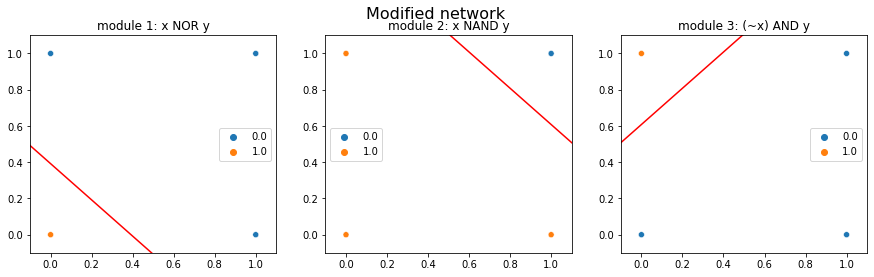

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def plot_points_and_line(ax, module, data_batch):
    y = t.sigmoid(module(data_batch)).round().detach()[:,0]
    lda = LinearDiscriminantAnalysis().fit(data_batch, y)
    x1 = np.array([-1, 2])
    b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
    y1 = -(b+x1*w1)/w2
    plot = sns.scatterplot(ax=ax, x=data_batch[:,0], y=data_batch[:,1], hue=y)
    plot.set_xlim(-0.1, 1.1)
    plot.set_ylim(-0.1, 1.1)
    plot.plot(x1,y1,c='r')
    return plot

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Modified network", fontsize=16)
plot_points_and_line(axes[0], hooked_net.a, data_batch).set_title('module 1: x NOR y')
plot_points_and_line(axes[1], hooked_net.b, data_batch).set_title('module 2: x NAND y')
plot_points_and_line(axes[2], hooked_net.c, data_batch).set_title('module 3: (~x) AND y')

print(f'First  module weight: {hooked_net.a.weight.detach()}, bias: {hooked_net.a.bias.detach()}')
print(f'Second module weight: {hooked_net.b.weight.detach()}, bias: {hooked_net.b.bias.detach()}')
print(f'Third  module weight: {hooked_net.c.weight.detach()}, bias: {hooked_net.c.bias.detach()}')


### What happened?

I think the network learnt how to perform the NOR operation in the first module (which evaluates to the same predicate as OR), NAND in the second (which evaluates to the same predicate as AND), and it had to learn to invert the first input and AND it with the second in the third module, as this is how XOR is typically composed out of linear operations.

We can also look at the weights, and compare them to what [one could come up with](https://github.com/pranavgade20/causal-verifier/blob/53cf02f24afff2cafb586fd753ce2330998ddb62/examples/example.py#L20) if asked to write down weights that perform these operations - the module that implements NOR has large negative weights, and a positive bias approximately equal to a third of the absolute value of the sum; the module that implements NAND has large negative weights, and a positive bias approximately equal to two-thirds of the absolute value of the sum; while the third module, which inverts one of the inputs and ANDs it with the other, appears to be less robust, with the bias being around a tenth of the sum of absolute values of the weights.

The modifications seem to work, as the unmodified network learns different functions which are arguably less straightforward to interpret.

First  module weight: tensor([[ 6.3114, -5.9263]]), bias: tensor([-3.5058])
Second module weight: tensor([[ 6.3001, -6.0117]]), bias: tensor([3.3297])
Third  module weight: tensor([[ 6.2536, -6.4361]]), bias: tensor([3.2282])


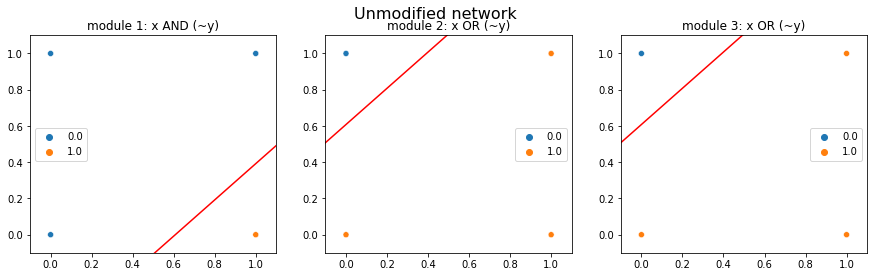

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Unmodified network", fontsize=16)
plot_points_and_line(axes[0], normal_net.a, data_batch).set_title('module 1: x AND (~y)')
plot_points_and_line(axes[1], normal_net.b, data_batch).set_title('module 2: x OR (~y)')
plot_points_and_line(axes[2], normal_net.c, data_batch).set_title('module 3: x OR (~y)')

print(f'First  module weight: {normal_net.a.weight.detach()}, bias: {normal_net.a.bias.detach()}')
print(f'Second module weight: {normal_net.b.weight.detach()}, bias: {normal_net.b.bias.detach()}')
print(f'Third  module weight: {normal_net.c.weight.detach()}, bias: {normal_net.c.bias.detach()}')


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loss curves:


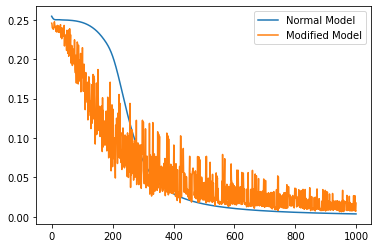

In [12]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob

plt.plot([i.summary.value[0].simple_value for i in summary_iterator(glob.glob('content/logs/normal_model/1.0.0/events*')[0]) if len(i.summary.value) > 0 and i.summary.value[0].tag == 'train/loss'])
plt.plot([i.summary.value[0].simple_value for i in summary_iterator(glob.glob('content/logs/hooked_model/1.0.0/events*')[0]) if len(i.summary.value) > 0 and i.summary.value[0].tag == 'train/loss'])
plt.legend(['Normal Model', 'Modified Model'])
print('Loss curves:')